# Understanding MTA system usage profile

Since the gala is in **early summer**, spring is optimal for locating the WTWY teams at the turnstiles: **March, April, and May**. We will look at MTA usage profiles over these three months for the current year, as a representative post-covid recovery year. We assume 2022 is likely to be more like 2021 than the pre-covid 2019, with increased work from home. Based on usage patterns over the **most typical weekdays and weekends**, we will recommend the **top twenty stations** to locate the street teams at. 

In [139]:
# Source: http://web.mta.info/developers/turnstile.html
# Ingesting MTA turnstile data for the months February, March, and April of 2021. 
# Adding a column with date and time combined. Converting it to datetime format (from string)

import pandas as pd
def get_data_parse_dt(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url, parse_dates=[['DATE','TIME']], keep_date_col=True))
    return pd.concat(dfs)
        
week_nums = [210306, 210313, 210320, 210327, 210403, 210410, 210417, 210424, 210501, 210508, 210515, 210522, 210529]
mta = get_data_parse_dt(week_nums)
mta.tail()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
208907,2021-05-28 08:20:35,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/28/2021,08:20:35,REGULAR,5554,577
208908,2021-05-28 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/28/2021,09:00:00,REGULAR,5554,577
208909,2021-05-28 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/28/2021,13:00:00,REGULAR,5554,577
208910,2021-05-28 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/28/2021,17:00:00,REGULAR,5554,577
208911,2021-05-28 21:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/28/2021,21:00:00,REGULAR,5554,577


In [140]:
mta.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,2021-02-27 03:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,03:00:00,REGULAR,7537255,2570434
1,2021-02-27 07:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,07:00:00,REGULAR,7537260,2570445
2,2021-02-27 11:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,11:00:00,REGULAR,7537285,2570500
3,2021-02-27 15:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,15:00:00,REGULAR,7537354,2570546
4,2021-02-27 19:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,19:00:00,REGULAR,7537501,2570582


## Data Exploration & Cleaning

In [141]:
# mta.iloc[:1690000].info() to get info on non-null columns. Does not work beyond 1690000 
#rows. Having looked at different sections of the data, it seems that missing data likely 
#not a problem.
mta.info()
mta.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2717757 entries, 0 to 208911
Data columns (total 12 columns):
 #   Column                                                                Dtype         
---  ------                                                                -----         
 0   DATE_TIME                                                             datetime64[ns]
 1   C/A                                                                   object        
 2   UNIT                                                                  object        
 3   SCP                                                                   object        
 4   STATION                                                               object        
 5   LINENAME                                                              object        
 6   DIVISION                                                              object        
 7   DATE                                                                  obj

,ENTRIES,EXITS
count,2.717757e+06,2.717757e+06
mean,4.191390e+07,3.370046e+07
std,2.184118e+08,1.935130e+08
min,0.000000e+00,0.000000e+00
25%,2.182960e+05,9.292700e+04
50%,1.458820e+06,8.723310e+05
75%,6.120656e+06,4.025068e+06
max,2.147432e+09,2.123010e+09


There are 2717757 rows and 12 columns. Strangely, there are more entries in the data than exits, which probably points to the fact that the more mornings are captured than evenings in the particular sample. The distances between the 75th percentile and max values are orders of magnitude greater than those between the 25th percentile and 75th percentile values. This possibly indicates that some very large outliers exist in the data, or that a few stations serve an extraordinarily large number of passengers. It might also be because of errors in the counters in the turnstiles.  

In [142]:
mta.columns #Found that EXITS had whitespace 
mta.columns = [column.strip() for column in mta.columns]
mta.columns #No more whitespace!

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [143]:
#Number of turnstiles in use on each date times the number of times each turnstile recorded counts 
mta.DATE.value_counts().sort_index().head(10)

02/27/2021    29985
02/28/2021    29763
03/01/2021    29868
03/02/2021    29803
03/03/2021    29871
03/04/2021    29918
03/05/2021    29867
03/06/2021    29927
03/07/2021    29849
03/08/2021    29932
Name: DATE, dtype: int64

A person is more likely to have time to respond on her way out of the station than while 
going in. While the number of entries into the station are most likely to be equal to the number of exits from the station over the course of the day, we will count exits to position the street teams at times when the number of exits are the largest. We hypothesize that this is in the evening peak. It is also the time when the most office-goers are expected to return home, likely the biggest champions for women in tech. 

Each set of C/A, Unit, SCP, Station represent a unique turnstile. 

In [144]:
#Counting the number of times exit records were sent from a unique turnstile on a specific 
#date and time-point in intervals of four hours. 

(mta
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .EXITS.count()
 .reset_index()
 .sort_values("EXITS", ascending=False)).head(80)

,C/A,UNIT,SCP,STATION,DATE_TIME,EXITS
737501,N071,R013,00-00-04,34 ST-PENN STA,2021-04-08 08:00:00,2
833187,N100,R252,00-00-00,HIGH ST,2021-03-09 07:00:00,2
833181,N100,R252,00-00-00,HIGH ST,2021-03-08 07:00:00,2
833182,N100,R252,00-00-00,HIGH ST,2021-03-08 11:00:00,2
833183,N100,R252,00-00-00,HIGH ST,2021-03-08 15:00:00,2
...,...,...,...,...,...,...
1115097,N324,R018,00-06-03,JKSN HT-ROOSVLT,2021-04-14 00:00:00,2
1805459,R138,R293,00-02-01,34 ST-PENN STA,2021-02-28 09:00:00,2
1077595,N310,R140,01-06-00,QUEENS PLAZA,2021-05-20 17:00:00,2
1131012,N329,R201,00-03-02,WOODHAVEN BLVD,2021-05-08 01:00:00,2


There are 2717678 groups in the data. In 79 instances, two records were sent back at the same instant for the same turnstile. This is an error that needs to be looked into. The column DESC consists of the regular scheduled audit event and the 'Recovr Aud' entries, which is a missed audit that was recovered. At these 79  instances, the Recovr Aud records likely came at the same time. 

In [145]:
#Looking into the DESC column:
mta.DESC.value_counts()

REGULAR       2707755
RECOVR AUD      10002
Name: DESC, dtype: int64

This reveals that there are far more than 79, actually 10002 RECOVR AUD values. A check on 
some of the 79 shows absurd values so those can be dropped. The remaining 9923 represent 
unique audit instances for turnstiles and should be checked to see the nature of values. However since these represent only 0.36% of the total data, and we do not have insider knowledge to validate if the Recovr Aud counts for those turnstiles are in the correct range, we will drop them. 

In [146]:
#We will drop all the Recovr Aud entries.
mta.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
mta.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [147]:
# Check to see if that takes care of all duplicate values in our data subset. Yes it does!
(mta
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .EXITS.count()
 .reset_index()
 .sort_values("EXITS", ascending=False)).head()

,C/A,UNIT,SCP,STATION,DATE_TIME,EXITS
0,A002,R051,02-00-00,59 ST,2021-02-27 03:00:00,1
1811779,R138,R293,00-05-01,34 ST-PENN STA,2021-04-17 02:00:00,1
1811781,R138,R293,00-05-01,34 ST-PENN STA,2021-04-17 10:00:00,1
1811782,R138,R293,00-05-01,34 ST-PENN STA,2021-04-17 14:00:00,1
1811783,R138,R293,00-05-01,34 ST-PENN STA,2021-04-17 18:00:00,1


In [148]:
#Reducing number of columns
mta = mta.drop(["DESC"], axis=1, errors="ignore")

In [149]:
#Since these are cumulative values, the largest count in the day will be the last count of 
#the day. Getting the largest counts of the day. 
mta_daily = (mta.groupby(["C/A", "UNIT", "SCP", "STATION","DATE"], as_index = False).EXITS.first())

In [150]:
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS
0,A002,R051,02-00-00,59 ST,02/27/2021,2570596
1,A002,R051,02-00-00,59 ST,02/28/2021,2570717
2,A002,R051,02-00-00,59 ST,03/01/2021,2570968
3,A002,R051,02-00-00,59 ST,03/02/2021,2571211
4,A002,R051,02-00-00,59 ST,03/03/2021,2571472


## To get the specific number of exits in the days instead of the cumulative

In [151]:
mta_daily[["PREV_DATE", "PREV_EXITS"]] = (mta_daily
                                      .groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "EXITS"]]
                                      .shift(1))
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXITS
0,A002,R051,02-00-00,59 ST,02/27/2021,2570596,NaN,NaN
1,A002,R051,02-00-00,59 ST,02/28/2021,2570717,02/27/2021,2570596.0
2,A002,R051,02-00-00,59 ST,03/01/2021,2570968,02/28/2021,2570717.0
3,A002,R051,02-00-00,59 ST,03/02/2021,2571211,03/01/2021,2570968.0
4,A002,R051,02-00-00,59 ST,03/03/2021,2571472,03/02/2021,2571211.0


In [152]:
#Drop the rows for the earliest date in the df
mta_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [153]:
#To get the description of the daily exits (non-cumulative):
(mta_daily["EXITS"] - mta_daily["PREV_EXITS"]).describe()

count    4.493030e+05
mean    -2.909352e+03
std      6.197147e+06
min     -1.804895e+09
25%      5.900000e+01
50%      2.060000e+02
75%      4.720000e+02
max      2.005379e+09
dtype: float64

In [154]:
#Negative values for the mean and the min means that there are instances for which the 
#later cumulative values are smaller than the earlier ones. Checking for such values: 
mta_daily[mta_daily["EXITS"] < mta_daily["PREV_EXITS"]].shape

(3067, 8)

There are 3067 such entries. 

In [155]:
mta_daily[mta_daily["EXITS"] < mta_daily["PREV_EXITS"]].head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXITS
387,A002,R051,02-03-02,59 ST,03/22/2021,88,03/21/2021,8869456.0
3550,A011,R080,01-03-00,57 ST-7 AV,02/28/2021,489658315,02/27/2021,489658832.0
3551,A011,R080,01-03-00,57 ST-7 AV,03/01/2021,489657460,02/28/2021,489658315.0
3552,A011,R080,01-03-00,57 ST-7 AV,03/02/2021,489656586,03/01/2021,489657460.0
3553,A011,R080,01-03-00,57 ST-7 AV,03/03/2021,489655757,03/02/2021,489656586.0


The data for the same station shows that the number of exits for a day equals the number of previous exits for the next day. Also that the cumulative values are decreasing by the day which means that the counters are operating in reverse. 

In [156]:
# Let's see how many turnstiles have this problem

(mta_daily[mta_daily["EXITS"] < mta_daily["PREV_EXITS"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A    UNIT  SCP       STATION      
A002   R051  02-03-02  59 ST             1
A011   R080  01-03-00  57 ST-7 AV       90
             01-03-03  57 ST-7 AV        1
             01-03-04  57 ST-7 AV        1
A013   R081  01-06-01  49 ST             1
                                        ..
R617   R058  00-00-02  BERGEN ST         1
R622   R123  00-00-00  FRANKLIN AV      90
R624   R124  00-00-02  KINGSTON AV       1
S101   R070  00-00-04  ST. GEORGE        1
TRAM2  R469  00-05-00  RIT-ROOSEVELT     2
Length: 207, dtype: int64

In [157]:
#Fixing the reverse counts and creating a DAILY_EXITS column as the difference of the 
#cumulative counts between two consecutive days. 

def get_daily_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        print(f'exits: {row["EXITS"]} <-- {row["PREV_EXITS"]}')
        counter = min(row["EXITS"], row["PREV_EXITS"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

mta_daily["DAILY_EXITS"] = mta_daily.apply(get_daily_counts, axis=1, max_counter=43200)

exits: 88 <-- 8869456.0
exits: 56 <-- 167440.0
exits: 517 <-- 995815.0
exits: 62 <-- 154037.0
exits: 6 <-- 808408.0
exits: 184 <-- 29823169.0
exits: 295 <-- 7504407.0
exits: 7 <-- 67960.0
exits: 338 <-- 662027.0
exits: 24 <-- 100287.0
exits: 104 <-- 436767770.0
exits: 0 <-- 469762048.0
exits: 8 <-- 763625201.0
exits: 0 <-- 3196184.0
exits: 137 <-- 2192493.0
exits: 76 <-- 197920.0
exits: 161 <-- 1075170.0
exits: 42 <-- 60538.0
exits: 116 <-- 1481691.0
exits: 0 <-- 1377854.0
exits: 671146416 <-- 2645604.0
exits: 39 <-- 2375240.0
exits: 181 <-- 440876.0
exits: 63 <-- 112339.0
exits: 0 <-- 67865.0
exits: 30 <-- 464084.0
exits: 4 <-- 45627.0
exits: 66 <-- 2944229.0
exits: 135 <-- 134694104.0
exits: 251 <-- 205767.0
exits: 68 <-- 1090165.0
exits: 143 <-- 94090.0
exits: 488 <-- 86053.0
exits: 3670425 <-- 3565480.0
exits: 3392585 <-- 3326644.0
exits: 51 <-- 6430045.0
exits: 14 <-- 751570.0
exits: 1429 <-- 15269731.0
exits: 1236 <-- 270797.0
exits: 58 <-- 6427794.0
exits: 196634 <-- 76419.0
exi

In [158]:
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXITS,DAILY_EXITS
1,A002,R051,02-00-00,59 ST,02/28/2021,2570717,02/27/2021,2570596.0,121.0
2,A002,R051,02-00-00,59 ST,03/01/2021,2570968,02/28/2021,2570717.0,251.0
3,A002,R051,02-00-00,59 ST,03/02/2021,2571211,03/01/2021,2570968.0,243.0
4,A002,R051,02-00-00,59 ST,03/03/2021,2571472,03/02/2021,2571211.0,261.0
5,A002,R051,02-00-00,59 ST,03/04/2021,2571750,03/03/2021,2571472.0,278.0


The data shows cumulative values increasing by the day. 

In [159]:
mta_daily.DAILY_EXITS.describe()

count    449303.000000
mean        346.041375
std         476.775232
min           0.000000
25%          63.000000
50%         209.000000
75%         477.000000
max       42290.000000
Name: DAILY_EXITS, dtype: float64

No more negative values although the maximum value is still orders of magnitude above the 75% value. Changing the max counter value affected the value of the max as well as the mean. At 1 person per second, the maximum throughput in 24 hours is 43200 persons. So we assumed that value for max counter and reran our code. 

In [160]:
daily_totals = (mta_daily#.reset_index() \
         .sort_values('DAILY_EXITS', ascending=False))
daily_totals

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXITS,DAILY_EXITS
432836,R610,R057,00-04-00,ATL AV-BARCLAY,04/16/2021,135,04/15/2021,42425.0,42290.0
281039,PTH22,R540,00-02-04,PATH NEW WTC,05/05/2021,252,05/04/2021,41322.0,41070.0
77967,H026,R137,00-03-01,MYRTLE-WYCKOFF,03/14/2021,28,03/13/2021,39847.0,39819.0
122908,N071,R013,00-03-00,34 ST-PENN STA,05/24/2021,1056352,04/08/2021,1017383.0,38969.0
279687,PTH22,R540,00-00-05,PATH NEW WTC,05/05/2021,278,05/04/2021,39171.0,38893.0
...,...,...,...,...,...,...,...,...,...
145138,N114,R297,01-05-01,FRANKLIN AV,04/08/2021,4,04/07/2021,4.0,0.0
145139,N114,R297,01-05-01,FRANKLIN AV,04/09/2021,4,04/08/2021,4.0,0.0
145140,N114,R297,01-05-01,FRANKLIN AV,04/10/2021,4,04/09/2021,4.0,0.0
145141,N114,R297,01-05-01,FRANKLIN AV,04/11/2021,4,04/10/2021,4.0,0.0


In [161]:
#daily_totals[(daily_totals['DAILY_EXITS'] > 43200)]

In [162]:
#daily_totals = (mta_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])['DAILY_EXITS'].sum() \
 #   .reset_index() \
  #  .sort_values('DAILY_EXITS', ascending=False))

#daily_totals.head(15)

# Visuals

In [164]:
import matplotlib.pyplot as plt
#import seaborn as sns
# %config InlineBackend.figure_formats = ['svg']  # or retina
# %matplotlib inline

#sns.set(context='notebook', 
    #style='whitegrid', 
    #font_scale=1.1)

In [165]:
import numpy as np

In [166]:
#plt.bar(x=daily_totals['STATION'][:20], height=daily_totals['DAILY_EXITS'][:20])
#plt.xticks(rotation=90);
#plt.ylabel("Daily Exits");

In [167]:
#getting data for a typical weekday: Wednesday
daily_totals['DAY_OF_WEEK_NUM'] = pd.to_datetime(daily_totals['DATE']).dt.dayofweek
mask = daily_totals.DAY_OF_WEEK_NUM == 2
daily_totals[mask].info()
Wednsdy = daily_totals[mask]
Wednsdy.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64898 entries, 281039 to 145137
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   C/A              64898 non-null  object 
 1   UNIT             64898 non-null  object 
 2   SCP              64898 non-null  object 
 3   STATION          64898 non-null  object 
 4   DATE             64898 non-null  object 
 5   EXITS            64898 non-null  int64  
 6   PREV_DATE        64898 non-null  object 
 7   PREV_EXITS       64898 non-null  float64
 8   DAILY_EXITS      64898 non-null  float64
 9   DAY_OF_WEEK_NUM  64898 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 5.4+ MB


,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXITS,DAILY_EXITS,DAY_OF_WEEK_NUM
281039,PTH22,R540,00-02-04,PATH NEW WTC,05/05/2021,252,05/04/2021,41322.0,41070.0,2
279687,PTH22,R540,00-00-05,PATH NEW WTC,05/05/2021,278,05/04/2021,39171.0,38893.0,2
269949,PTH13,R541,00-04-08,THIRTY ST,04/21/2021,60017,04/20/2021,22758.0,37259.0,2
279596,PTH22,R540,00-00-04,PATH NEW WTC,05/05/2021,748,05/04/2021,18451.0,17703.0,2
278868,PTH21,R540,01-00-01,PATH WTC 2,05/05/2021,186,05/04/2021,17550.0,17364.0,2


In [173]:
#daily_totals_short = daily_totals.drop(["PREV_DATE", "PREV_EXITS"], axis=1, errors="ignore")
#daily_totals_short.head()
avg_Wednsdy_byloc = (Wednsdy
                    .groupby(["C/A", "UNIT", "SCP", "STATION"])
                    .DAILY_EXITS.median()
                    .reset_index()
                    .sort_values('DAILY_EXITS', ascending=False))
avg_Wednsdy_byloc.head(15)

,C/A,UNIT,SCP,STATION,DAILY_EXITS
1310,N063A,R011,00-00-00,42 ST-PORT AUTH,4421.0
1311,N063A,R011,00-00-01,42 ST-PORT AUTH,3526.0
4021,R249,R179,01-00-09,86 ST,3491.0
2040,N324,R018,00-03-00,JKSN HT-ROOSVLT,3184.0
4606,R528,R097,00-00-00,JUNCTION BLVD,3152.0
859,H026,R137,00-00-00,MYRTLE-WYCKOFF,3101.0
3352,R138,R293,00-03-04,34 ST-PENN STA,2844.0
3903,R240,R047,00-00-00,GRD CNTRL-42 ST,2824.0
3521,R169,R168,01-03-00,96 ST,2779.0
1414,N083,R138,01-00-00,W 4 ST-WASH SQ,2692.0


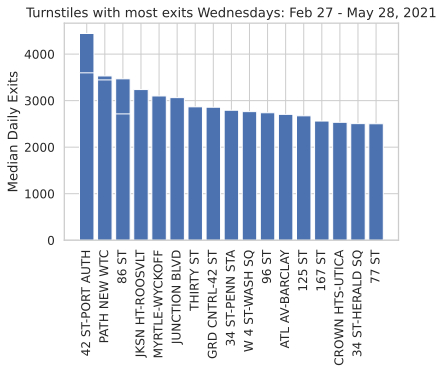

In [170]:
plt.bar(x=avg_Wednsdy_byloc['STATION'][:20], height=avg_Wednsdy_byloc['DAILY_EXITS'][:20])
plt.title('Turnstiles with most exits Wednesdays: Feb 27 - May 28, 2021')
plt.xticks(rotation=90)
plt.ylabel("Median Daily Exits")
plt.savefig('Final.png', dpi=300, bbox_inches='tight')

In [ ]:
#data = avg_Wednsdy_byloc
#sns.barplot(x = 'STATION'[:10],y='DAILY_EXITS',data=avg_Wednsdy_byloc);

In [188]:
#getting data for a Saturday
daily_totals['DAY_OF_WEEK_NUM'] = pd.to_datetime(daily_totals['DATE']).dt.dayofweek
mask = daily_totals.DAY_OF_WEEK_NUM == 5
daily_totals[mask].info()
Saturdy = daily_totals[mask]
Saturdy.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59910 entries, 326247 to 145140
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   C/A              59910 non-null  object 
 1   UNIT             59910 non-null  object 
 2   SCP              59910 non-null  object 
 3   STATION          59910 non-null  object 
 4   DATE             59910 non-null  object 
 5   EXITS            59910 non-null  int64  
 6   PREV_DATE        59910 non-null  object 
 7   PREV_EXITS       59910 non-null  float64
 8   DAILY_EXITS      59910 non-null  float64
 9   DAY_OF_WEEK_NUM  59910 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 5.0+ MB


,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXITS,DAILY_EXITS,DAY_OF_WEEK_NUM
326247,R190,R038,00-00-01,215 ST,05/01/2021,29,04/30/2021,32913.0,32884.0,5
78022,H026,R137,00-03-01,MYRTLE-WYCKOFF,05/08/2021,79,05/07/2021,8352.0,8273.0,5
21252,A052,R088,01-00-02,CORTLANDT ST,03/06/2021,39,03/05/2021,6398.0,6359.0,5
417531,R528,R097,00-00-04,JUNCTION BLVD,03/13/2021,1498295,03/12/2021,1493392.0,4903.0,5
417545,R528,R097,00-00-04,JUNCTION BLVD,03/27/2021,1528232,03/26/2021,1523863.0,4369.0,5


In [190]:
#daily_totals_short = daily_totals.drop(["PREV_DATE", "PREV_EXITS"], axis=1, errors="ignore")
#daily_totals_short.head()
avg_Saturdy_byloc = (Saturdy
                    .groupby(["C/A", "UNIT", "SCP", "STATION"])
                    .DAILY_EXITS.median()
                    .reset_index()
                    .sort_values('DAILY_EXITS', ascending=False))
avg_Saturdy_byloc.head(15)

,C/A,UNIT,SCP,STATION,DAILY_EXITS
1414,N083,R138,01-00-00,W 4 ST-WASH SQ,2974.0
859,H026,R137,00-00-00,MYRTLE-WYCKOFF,2827.0
2040,N324,R018,00-03-00,JKSN HT-ROOSVLT,2756.0
1415,N083,R138,01-00-01,W 4 ST-WASH SQ,2586.5
2415,N506,R022,00-05-05,34 ST-HERALD SQ,2583.5
1310,N063A,R011,00-00-00,42 ST-PORT AUTH,2510.5
125,A034,R170,03-00-00,14 ST-UNION SQ,2324.5
4020,R249,R179,01-00-09,86 ST,2255.5
1407,N080,R138,00-00-00,W 4 ST-WASH SQ,2181.5
1311,N063A,R011,00-00-01,42 ST-PORT AUTH,2162.0


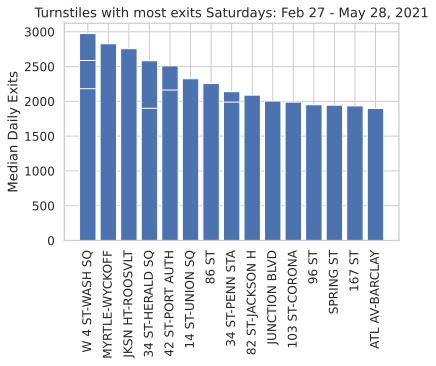

In [191]:
plt.bar(x=avg_Saturdy_byloc['STATION'][:20], height=avg_Saturdy_byloc['DAILY_EXITS'][:20])
plt.title('Turnstiles with most exits Saturdays: Feb 27 - May 28, 2021')
plt.xticks(rotation=90)
plt.ylabel("Median Daily Exits")
plt.savefig('Saturday.png', dpi=300, bbox_inches='tight')

In [187]:
#SUBSEQUENT PLOTs DID NOT WORK :(
#plot multiple times on same axis
#each line is one week, one group in our df
plt.figure(figsize=(15,8))
for i, group in daily_totals.groupby('STATION'): #for each TURNSTILE in our groupby
    plt.plot(group['DATE'], group['DAILY_EXITS'], label = i)#create multiple plots, or lines

plt.legend(shadow = True, loc = 0, fontsize = 'small') 

plt.xlabel('Date')
plt.ylabel('Number of turnstile exits')
plt.xticks(rotation=90)
plt.title('Ridership per day for top 5 stations');

In [185]:
#hue
#daily_totals['WEEK_OF_YEAR'] = daily_totals['WEEK_OF_YEAR'].astype(str) 
#needs to be categorical for hue
#sns.lineplot(data= daily_totals, x = "DAY_OF_WEEK_NUM", y = "DAILY_ENTRIES", hue = "WEEK_OF_YEAR")

KeyError: 'WEEK_OF_YEAR'

In [174]:
#daily_totals['DATE']=pd.to_datetime['DATE']
#stations = ['42 ST-PORT AUTH','6 AV']
#fig = plt.figure(figsize=(11,6))
#ax = fig.add_subplot(1,1,1)
#for station in stations:
    #df_station = daily_totals[daily_totals.STATION==station]
    #groupdate = df_station.groupby('DATE').sum()
    #ax.plot(df_station['DATE'], df_station['EXITS'])

In [175]:
#daily_totals.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXITS,DAILY_EXITS,DAY_OF_WEEK_NUM
432836,R610,R057,00-04-00,ATL AV-BARCLAY,04/16/2021,135,04/15/2021,42425.0,42290.0,4
281039,PTH22,R540,00-02-04,PATH NEW WTC,05/05/2021,252,05/04/2021,41322.0,41070.0,2
77967,H026,R137,00-03-01,MYRTLE-WYCKOFF,03/14/2021,28,03/13/2021,39847.0,39819.0,6
122908,N071,R013,00-03-00,34 ST-PENN STA,05/24/2021,1056352,04/08/2021,1017383.0,38969.0,0
279687,PTH22,R540,00-00-05,PATH NEW WTC,05/05/2021,278,05/04/2021,39171.0,38893.0,2


In [183]:
daily_by_turnstile = ((daily_totals
                       .groupby(['STATION', 'DATE']))
                       .DAILY_EXITS.sum()
                       .reset_index())
station_mask = ((daily_by_turnstile['STATION'] == '42 ST-PORT AUTH'))# | 
#(daily_by_turnstile['STATION'] == 'PATH NEW WTC') |
#(daily_by_turnstile['STATION'] == '86 ST') |
#(daily_by_turnstile['STATION'] == 'JKSN HT-ROOSVLT') | 
#(daily_by_turnstile['STATION'] == 'MYRTLE-WYCKOFF'))

daily_by_turnstile_max = daily_by_turnstile[station_mask].reset_index
                

In [177]:
#daily_by_turnstile_top['DAY_OF_WEEK_NUM'] = pd.to_datetime(daily_by_turnstile_top['DATE']).dt.dayofweek
#daily_by_turnstile_top

In [178]:
#daily_by_turnstile_sum = (daily_by_turnstile_top.groupby(['STATION', 'DAY_OF_WEEK_NUM']), DAILY_EXITS.SUM().reset_index())
#daily_by_turnstile_sum.head()

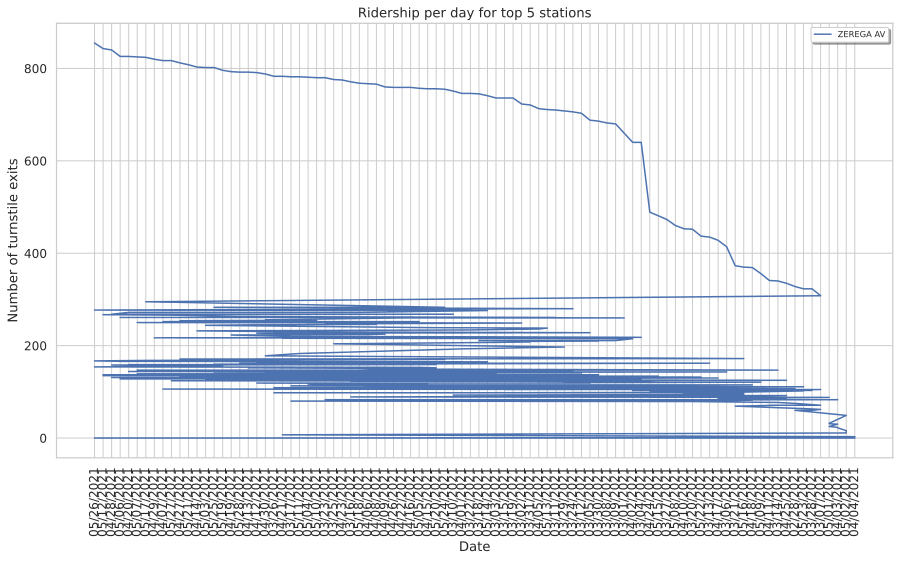

In [180]:
#plot multiple times on same axis
#each line is one week, one group in our df
# plt.figure(figsize=(15,8))
# #for i, group in daily_by_turnstile_max.groupby('STATION'): #for each TURNSTILE in our groupby
# plt.plot(group['DATE'], group['DAILY_EXITS'], label = i)#create multiple plots, or lines

# plt.legend(shadow = True, loc = 0, fontsize = 'small') 

# plt.xlabel('Date')
# plt.ylabel('Number of turnstile exits')
# plt.xticks(rotation=90)
# plt.title('Ridership per day for top 5 stations');

In [184]:
#import seaborn as sns
#daily_by_turnstile_max[['DATE','DAILY_EXITS']].set_index('DATE').plot()

TypeError: 'method' object is not subscriptable

In [181]:
# plt.figure(figsize=(15,8))
# x = daily_by_turnstile_max['DATE']
# y = daily_by_turnstile_max['DAILY_EXITS']
# plt.plot(x,y)
# plt.title('Turnstiles with most exits Wednesdays: Feb 27 - May 28, 2021')
# plt.xticks(rotation=90)
# plt.ylabel("Median Daily Exits")
#plt.savefig('Final.png', dpi=300, bbox_inches='tight')

TypeError: 'method' object is not subscriptable

<Figure size 1080x576 with 0 Axes>

In [ ]:
# df = pandas.DataFrame({
#     'Factor': ['Growth', 'Value'],
#     'Weight': [0.10, 0.20],
#     'Variance': [0.15, 0.35]
# })
# fig, ax1 = pyplot.subplots(figsize=(10, 10))
# tidy = df.melt(id_vars='Factor').rename(columns=str.title)
# seaborn.barplot(x='Factor', y='Value', hue='Variable', data=tidy, ax=ax1)
# seaborn.despine(fig)